# Creating a hacking detection engine

## Introduction

The goal of this tutorial is to use various data science techniques coupled with machine learning in order to create models that can detect and categorize adversaries and the techniques they use when hacking into computer networks.

The first portion of this tutorial will attempt to detect "commercial" malware, this is malware developed by criminals with the goal of either stealing money, or joining the computer to a larger botnet (access to the computing resources of this botnet is usually sold and used to perform large-scale denial of service attacks (DDOS) such as the case of [mirai](https://en.wikipedia.org/wiki/Mirai_(malware)). Commercial malware does not usually attempt to evade detections, and leaves a very large footprint on the system. I will attempt to train a model to detect the footprint left by this malware

The second portion of this tutorial will attempt to detect and classify the activity of nation state actors. These are known as [advanced persistent threats](https://en.wikipedia.org/wiki/Advanced_persistent_threat) (APTs). These groups of highly skilled and efficient attackers usually gain access into networks using highly target e-mails (spear phishing). Once a victim opens the e-mail and the attached file or clicks the attached link, a remote access trojan will be installed on the machine which will give the APT access to the network. Once access has been gained, these groups will attempt to evade detection as much as possible by leveraging existing applications pre-installed with windows. This is the exact type of activity I will attempt to detect.

This tutorial will work completely in a windows enviroment.

Our analysis will be leveraging domain knowledge of malware analysis and intrusion detection. Since this tutorial is aimed to be self-contained, please read the [following description](https://docs.microsoft.com/en-us/sysinternals/downloads/sysmon#events) of sysmon event types. This will provide a brief description into why we are pulling these specific logs from the virtual machine we will setup.

## Required Tools

* Python 3 and the science stack (numpy, pandas, sklearn, etc)
* VMWare Fusion
* Windows 7 ISO

# Enviroment Setup

Before we start, we need a __safe enviroment__ to execute our malicious code and to emulate the adversaries we are trying to detect. This step is extremely important, as when analyzing malicious code we need to ensure that we do not put ourselves or anyone on our network in danger.

I highly recommend this [guide](https://blog.christophetd.fr/malware-analysis-lab-with-virtualbox-inetsim-and-burp/) for setting up a complete malware analysis virtual enviroment. This tutorial will only set up a single windows virtual machine, disconnected from the outside internet, with a few tools in order to generate data we are able to analyze. The environment setup below is in __no way a suitable malware analysis enviroment__.

It is important to following the following sections __in order__ in order to be able to properly configure the virtual machine.

### Virtual Machine Setup

This set of instruction assumes the usage of [VMWare Fusion 10](https://my.vmware.com/web/vmware/info?slug=desktop_end_user_computing/vmware_fusion/10_0).

To get started, we will be using a Windows 7 guest machine, as of 2017/12/07 this operating system is currently the [most used](https://en.wikipedia.org/wiki/Usage_share_of_operating_systems#Desktop_and_laptop_computers) in the world. An ISO image of the operating system is available from [here](https://www.microsoft.com/en-us/software-download/windows7). 

__Note!__: Make sure you set a password, this will make automating file transfers between our desktop and VM much easier.

The following [tutorial](https://kb.vmware.com/s/article/1011677) can be used to set up the initial virtual machine. 

Once that tutorial is completed, the following changes should be made to ensure the machine cannot communicate to the internet. Going to Virtual Machine -> Settings -> Network Adapter, uncheck the "connect network adapter" setting.


<img src="static/imgs/uncheck_network_adapter.png" width=400 height=400>

Again, this is the only virtual machine configuration step we will do in this tutorial, but is important enough to show explicitly how to do it.

### Windows Image Configuration


#### Sysmon

In order to log the various action malware does on our system, we will use [sysmon](https://docs.microsoft.com/en-us/sysinternals/downloads/sysmon). The reasoning for this is further explained in the Data Collection section. 

We will be using the [ion-storm](https://github.com/ion-storm/sysmon-config) sysmon configuration file. This configuration file does considerable whitelisting of activity from the machine, which will lower the amount of cleaning we will have to do in the long run. I have made one change in order to capture _any_ DNS request made (`<DestinationHostname condition="contains">.</DestinationHostname>`)

The copy used at the time of writing this tutorial is available under `etc/sysmon-config.xml` in the github repository.

To set up the sysmon agent, simply download sysmon and the configuration file from their respective links. Copy them over to the virtual machine (VM), open an administrative command prompt (start -> type cmd.exe -> right click, run as adminsitrator), and in the folder where sysmon and the configuration file are located run `sysmon.exe -accepteula -i sysmonconfig-export.xml`. This will launch the sysmon agent. You will be presented with the following messages if everything was executed correctly:

<img src="static/imgs/sysmon_installed.png" width=400 height=400>

### Snapshot

The primary reason we are using a VM to generate data (outside of the ability to segment it off the internet) is that we are able to take snapshots of the state of our VM. After a snapshot is created we can easily revert our machine to the state it was in the snapshot. This is important when dealing with malware since we want the ability to revert our analysis machine to a clean state in order to re-execute the malware. This is even more important in data science since we will have a baseline for all our logs, we will be able to extract only the logs from the machine after the snapshot occurs, thus giving us only the logs relevant to the actions or malware we are currently creating events for.

To take a snapshot simply do Virtual Machine -> Take Snapshot

<img src="static/imgs/take_snapshot.png" width=400 height=400>

I renamed my snapshot from the snapshot manager (Virtual Machine -> Take Snapshot) to "Sysmon installed" for clarity.

<img src="static/imgs/renamed_snapshot.png" width=200 height=200>



That's it! Our enviroment is set up for running some bad code and emulating some elite hackers!

# Data Collection

We need to be able to represent the actions performed on our virtual machine in some way. To accomplish this we will be collecting the log generate by Sysmon from our system.
 
1. __Sysmon logs__ $\rightarrow$ This is the agent we installed in part one, its logs are available at:
    * `C:\Windows\System32\winevt\Logs\Microsoft-Windows-Sysmon%4Operational.evtx`


## Fetching from VM

We can use the VMWare `vmrun` command to fetch files and send files to our analysis VM. This will make ingesting the sysmon logs much easier.

We can bring back a file 

```bash
| => vmrun -T ws copyFileFromGuestToHost -u <windows_username> -p <windows_password> <path_to_.vmx file> <file_on_vm> <name_on_our_pc>
```

So in order to grab back the sysmon file we can do:

```bash
| => vmrun -T ws copyFileFromGuestToHost -u admin -p admin "/Users/yampelo/Documents/Virtual Machines.localized/Windows 7 x64.vmwarevm" "C:\Windows\System32\winevt\Logs\Microsoft-Windows-Sysmon%4Operational.evtx" "Microsoft-Windows-Sysmon%4Operational.evtx"
```


These `.evtx` files are not standard text files, they are a special format and will require some parsing. The below shows the file header of the sysmon event log.


```shell
| => file Microsoft-Windows-Sysmon%4Operational.evtx
Microsoft-Windows-Sysmon%4Operational.evtx: MS Windows Vista Event Log, 1 chunks (no. 0 in use), empty, DIRTY

| => xxd -l 32 Microsoft-Windows-Sysmon%4Operational.evtx
00000000: 456c 6646 696c 6500 0000 0000 0000 0000  ElfFile.........
00000010: 0000 0000 0000 0000 0100 0000 0000 0000  ................
```

##  `.evtx` Conversion

We will need to convert these `.evtx` files to something pandas can ingest.

We will be using a parsing library [python-evtx](https://github.com/williballenthin/python-evtx) to work with these files.

Let's try to convert a basic Sysmon event log into a dataframe. The sample file is available under `data/filetype_examples/Microsoft-Windows-Sysmon%4Operational.evtx`

In [1]:
import pprint
import Evtx.Evtx as evtx

def sysmon_evtx_to_dataframe(file):
    """Take an evtx file and convert it to a pandas dataframe
    
    Slightly modified from the below to return a dict instead of a string
    
    :param file: The .evtx file
    """
    
    def parse_record(record):
        """Convert an lxml record from sysmon into a dictionary
        :param record: lxml record from a sysmon evtx file
        """
        out = {}
        for node in record:
            parent = node.tag.split("}")[-1]
            for child in node:
                if parent == "EventData":
                    event_data_type = child.attrib['Name']
                    out[parent + "_" + event_data_type] = child.text
                else:
                    child_name = child.tag.split("}")[-1]
                    if len(child.attrib) > 0:
                        for k, v in child.attrib.items():
                            out[child_name + "_" + k] = v
                        out[child_name] = child.text
        return out
 
    
    events = []
    with evtx.Evtx(file) as log:
        for record in log.records():
            evt = parse_record(record.lxml())
            events.append(evt)
    return pd.DataFrame(events)

In [2]:
import pandas as pd
sysmon_df = sysmon_evtx_to_dataframe("data/filetype_examples/Microsoft-Windows-Sysmon%4Operational.evtx")

sysmon_df[sysmon_df.EventID == "1"].sample(1)

,Correlation,Correlation_ActivityID,Correlation_RelatedActivityID,EventData_CommandLine,EventData_Configuration,EventData_ConfigurationFileHash,EventData_CreationUtcTime,EventData_CurrentDirectory,EventData_DestinationHostname,EventData_DestinationIp,...,Execution,Execution_ProcessID,Execution_ThreadID,Provider,Provider_Guid,Provider_Name,Security,Security_UserID,TimeCreated,TimeCreated_SystemTime
6,None,,,C:\Windows\system32\ipconfig /renew,NaN,NaN,NaN,C:\Windows\system32\,NaN,NaN,...,None,624,2608,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-07 04:17:22.747120


In [3]:
sysmon_df.columns

Index(['Correlation', 'Correlation_ActivityID',
       'Correlation_RelatedActivityID', 'EventData_CommandLine',
       'EventData_Configuration', 'EventData_ConfigurationFileHash',
       'EventData_CreationUtcTime', 'EventData_CurrentDirectory',
       'EventData_DestinationHostname', 'EventData_DestinationIp',
       'EventData_DestinationIsIpv6', 'EventData_DestinationPort',
       'EventData_DestinationPortName', 'EventData_Details',
       'EventData_EventType', 'EventData_Hashes', 'EventData_Image',
       'EventData_Initiated', 'EventData_IntegrityLevel',
       'EventData_LogonGuid', 'EventData_LogonId',
       'EventData_ParentCommandLine', 'EventData_ParentImage',
       'EventData_ParentProcessGuid', 'EventData_ParentProcessId',
       'EventData_ProcessGuid', 'EventData_ProcessId', 'EventData_Protocol',
       'EventData_SchemaVersion', 'EventData_SourceHostname',
       'EventData_SourceIp', 'EventData_SourceIsIpv6', 'EventData_SourcePort',
       'EventData_SourcePortNam

It is pretty clear to see that our dataframe is very sparse. This is because sysmon has __21__ different event IDs that it monitors, and each of the event types has its own set of `EventData_*` keys to represent its specific data. Below is an array describing some of them. A full reference and description can be seen [here](https://docs.microsoft.com/en-us/sysinternals/downloads/sysmon#events): 


|ID|Event Type|
|--|--|
|1|Process creation
|3|Network connection
|5|Process terminated
|11|FileCreate
|12|RegistryEvent (Object create and delete)|
|13|RegistryEvent (Value Set)|
|14|RegistryEvent (Key and Value Rename)|


But otherwise we have now gotten over the main hurdle of the data collection step, we are now able to get events from our analysis VM into a pandas dataframe. 

I will define a function below that takes in a event ID and returns the event type. This will be useful when doing EDA to find out exactly what events occur a lot.


In [4]:
def event_type_from_id(event_id):
    """Get the event type from the ID
    
    :param event_id: Event ID to decode
    """
    
    event_id = str(event_id)
    types = {
        "1":"Process creation",
        "2":"A process changed a file creation time",
        "3":"Network connection",
        "4":"Sysmon service state changed",
        "5":"Process terminated",
        "6":"Driver loaded",
        "7":"Image loaded",
        "8":"CreateRemoteThread",
        "9":"RawAccessRead",
        "10":"ProcessAccess",
        "11":"FileCreate",
        "12":"RegistryEvent (Object create and delete)",
        "13":"RegistryEvent (Value Set)",
        "14":"RegistryEvent (Key and Value Rename)",
        "15":"FileCreateStreamHash",
        "16":"Sysmon config change",
        "17":"PipeEvent (Pipe Created)",
        "18":"PipeEvent (Pipe Connected)",
        "19":"WmiEvent (WmiEventFilter activity detected)",
        "20":"WmiEvent (WmiEventConsumer activity detected)",
        "21":"WmiEvent (WmiEventConsumerToFilter activity detected)",
        "255":"Error"
    }
    return types[event_id]

## Creating "Good" Labeled Data

Since this is a classification problem, and we wish to know if we can classify activity on our machine as good activity, or as malicious activity, we will need to generate a set of data to represent the good activity.

In order to do this we can launch our VM and mimick normal usage. To do this I simply opened the VM, and installed the following:
1. Word
2. Powerpoint
3. Chrome
4. Spotify
5. Adobe Acrobat

After that, i went to the CMSC320 class website, downloaded some PDFs, opened some powerpoints, created some word documents, and browsed the internet.

The above should accuratly represent what an normal user does on their machine.

I then copied over the the event logs using the command mentioned in [the set up section](#Fetching-from-VM). The file is available under `data/baseline/baseline_good.evtx`. 


### Clearing baseline from system

Now that we have created a baseline, we don't want to re-analyze this baseline each time, we want to only ingest new data and classify it. This will also be useful when creating our labeled malicious data later on.

We can wipe the sysmon logs from the machine by running the following command:

<img src="static/imgs/clear_sysmon_logs.png" width=500 height=500>

`wevtutil cl Microsoft-Windows-Sysmon/Operational`

This will wipe the `.evtx` file which Sysmon logs to.

We can now take a look at the baseline data we have created

## Exploratoriy Data Analysis of "Good" Data

Let's run it through our parser and do some EDA to determine if the baseline is good enough.

In [5]:
baseline = sysmon_evtx_to_dataframe("data/baseline/baseline_good.evtx")

baseline.shape

(16466, 70)

Looks like we have around 16,000 events. That seems like a good chunk. Let's use seaborn to see what kind of data we have.

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

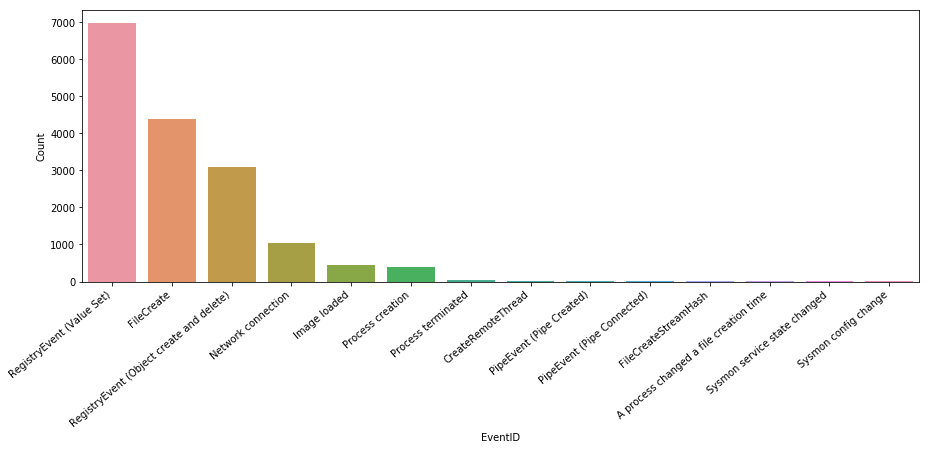

In [7]:
fig, ax = plt.subplots(figsize=(15,5))

count_by_event_id = pd.DataFrame(baseline['EventID'].value_counts())
count_by_event_id.rename(columns={"EventID": "Count"}, inplace=True)
count_by_event_id['EventID'] = count_by_event_id.index 
count_by_event_id['EventID'] = count_by_event_id['EventID'].apply(event_type_from_id) 
sns.barplot(x="EventID", y="Count", data=count_by_event_id, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.show()

Looks like the Registery ValueSet command is the most prominent one. Let's see what kind of information we can learn about normal usage and what kind of data is available from that since that is our largest sample currently. 

In [8]:
# Grab the event ID of registery ValueSet
registry_value_set = baseline[baseline['EventID'] == "13"] 

# Drop all rows that are empty for all events. This happens because of how spares our features are 
registry_value_set = registry_value_set.dropna(axis=1)

registry_value_set.head()

,Correlation_ActivityID,Correlation_RelatedActivityID,EventData_Details,EventData_EventType,EventData_Image,EventData_ProcessGuid,EventData_ProcessId,EventData_TargetObject,EventData_UtcTime,EventID,EventID_Qualifiers,Execution_ProcessID,Execution_ThreadID,Provider_Guid,Provider_Name,Security_UserID,TimeCreated_SystemTime
16,,,0.0.0.0,SetValue,C:\Windows\System32\svchost.exe,{1a8edbb7-bde0-5a28-0000-0010e2120100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\service...,2017-12-08 00:35:35.638,13,,624,2608,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 00:35:35.778996
17,,,255.0.0.0,SetValue,C:\Windows\System32\svchost.exe,{1a8edbb7-bde0-5a28-0000-0010e2120100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\service...,2017-12-08 00:35:35.638,13,,624,2608,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 00:35:35.778996
18,,,255.255.255.255,SetValue,C:\Windows\System32\svchost.exe,{1a8edbb7-bde0-5a28-0000-0010e2120100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\service...,2017-12-08 00:35:35.638,13,,624,2608,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 00:35:35.778996
20,,,0.0.0.0,SetValue,C:\Windows\System32\svchost.exe,{1a8edbb7-bde0-5a28-0000-0010e2120100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\service...,2017-12-08 00:35:36.903,13,,624,2608,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 00:35:36.919613
21,,,255.0.0.0,SetValue,C:\Windows\System32\svchost.exe,{1a8edbb7-bde0-5a28-0000-0010e2120100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\service...,2017-12-08 00:35:36.903,13,,624,2608,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 00:35:36.919613


Looks like we can see which process changes keys the most often

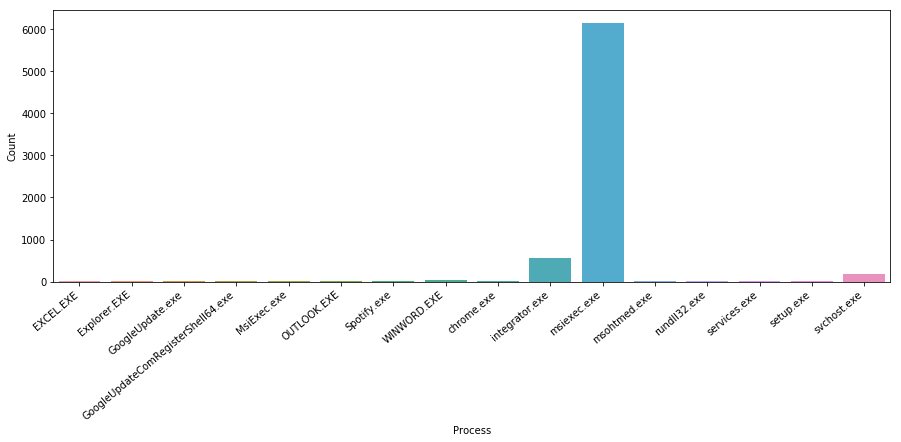

In [9]:
# Extract the process making the change from the EventData_Image Row
registry_value_set['Process'] = registry_value_set['EventData_Image'].apply(lambda x: x.split("\\")[-1])

# Let's see what registry key is the most often manipulated.
process_target_pair = registry_value_set.groupby(["Process"]).count()['EventID'].reset_index()
process_target_pair = process_target_pair.rename(columns={"EventID" : "Count"})

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x="Process", y="Count", data=process_target_pair, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

This is actually really interesting. The `msiexec.exe` process is the windows installer, and `integrator.exe` is an executable used by VMWare Fusion to let us interact with the VM. We may have such a high amount of data for these processes setting registry keys since we had sysmon installed while installing office, spotify, and adobe acrobat in the `msiexec.exe` case; and from normal usage of the VM in the `integrator.exe` case. Let's try removing these and doing this again

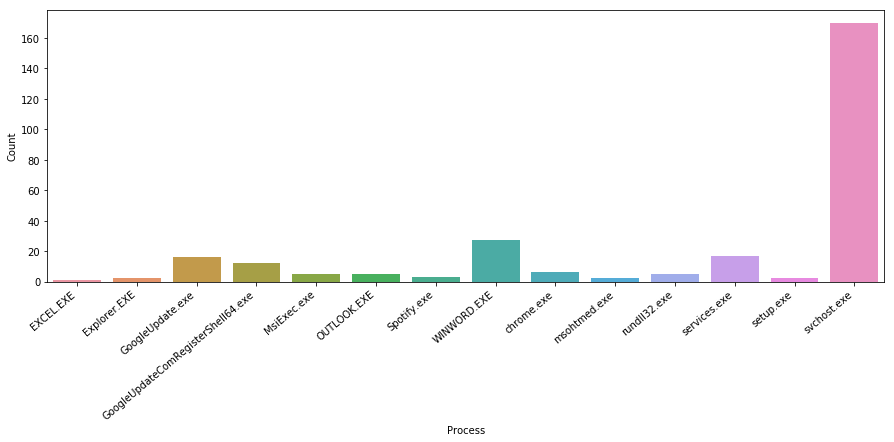

In [10]:
process_target_pair = registry_value_set[(registry_value_set.Process != "integrator.exe") &
                                         (registry_value_set.Process != "msiexec.exe")].groupby(
    ["Process"]
).count()['EventID'].reset_index()

process_target_pair = process_target_pair.rename(columns={"EventID" : "Count"})

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x="Process", y="Count", data=process_target_pair, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

This looks much better! We know have a distribution of which processes are active at modifying the registry and which are not. Let's see what keys are changed the most.


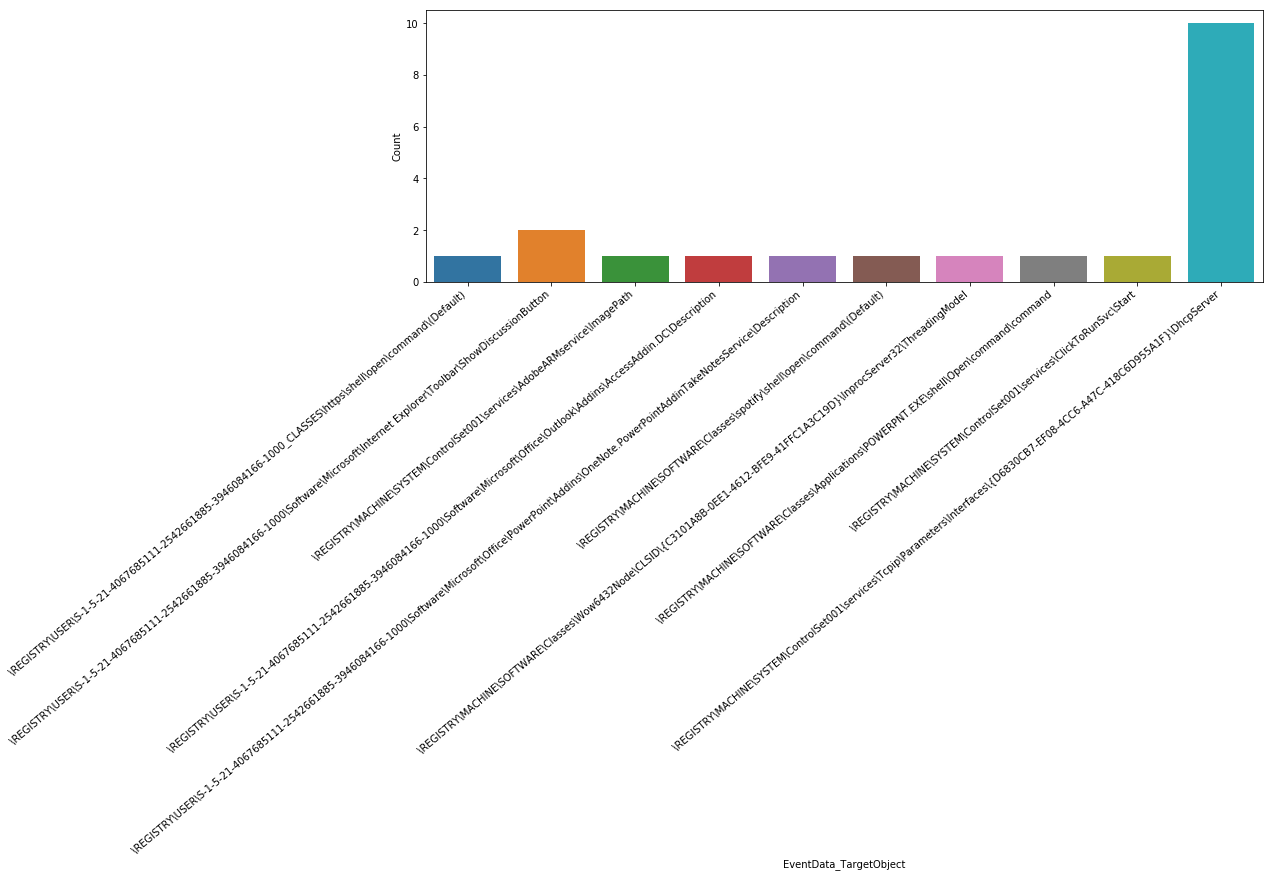

In [13]:
most_frequent_key_changed = registry_value_set[(registry_value_set.Process != "integrator.exe") &
                                               (registry_value_set.Process != "msiexec.exe")].groupby(
    ["EventData_TargetObject"]
).count()['EventID'].reset_index()

most_frequent_key_changed = most_frequent_key_changed.rename(columns={"EventID" : "Count"})

# Graph gets crazy, lets plot a sample
most_frequent_key_changed = most_frequent_key_changed.sample(10)

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x="EventData_TargetObject", y="Count", data=most_frequent_key_changed, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

It looks like sysmon stores the values including the [registry hives](https://msdn.microsoft.com/en-us/library/windows/desktop/ms724877.aspx).

This is not relevant as it will change on a per computer basis, for example the SID (S-1-XXX-XXX) is a unique identifier for a user, we dont want to train our algorithm to only work on one computer). These will always be the first two segment of the key (first two values seperated by slashes). Let's remove those for this to get a better distribution.


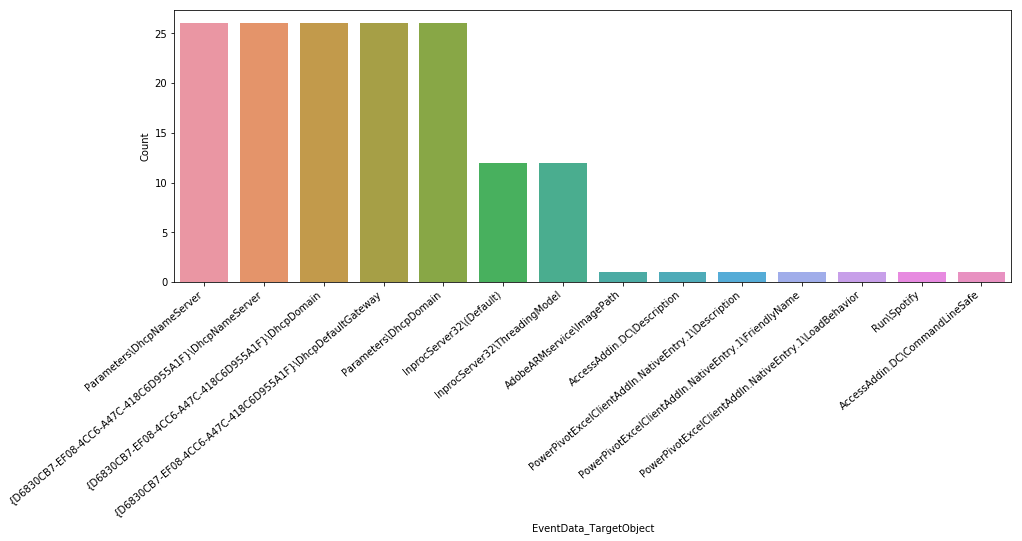

In [14]:
# Remove the hive
registry_value_set['EventData_TargetObject'] = registry_value_set['EventData_TargetObject'].apply(
    lambda x: '\\'.join(x.split("\\")[-2:])
)

most_frequent_key_changed_no_hive = registry_value_set[(registry_value_set.Process != "integrator.exe") &
                                                       (registry_value_set.Process != "msiexec.exe")].groupby(
    ["EventData_TargetObject"]
).count()['EventID'].reset_index()

most_frequent_key_changed_no_hive = most_frequent_key_changed_no_hive.rename(columns={"EventID" : "Count"})

most_frequent_key_changed_no_hive.sort_values(by="Count", inplace=True, ascending=False)

# The graph gets a bit crazy, let's plot the last 7 and top 7

most_frequent_key_changed_no_hive = most_frequent_key_changed_no_hive.head(7).append(
    most_frequent_key_changed_no_hive.tail(7)
)

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x="EventData_TargetObject", y="Count", data=most_frequent_key_changed_no_hive, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()